#setup models and data

In [ ]:
!pip install wandb

In [11]:
import wandb
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
from random import shuffle
from tqdm.auto import tqdm
import requests
import zipfile
from pathlib import Path

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

apikey = "7a8ee9d41cc2d51eb77fd795e14f74a215e63c2d"
api = wandb.Api()
artifact_syn = api.artifact('ecg_simula/setup_weights and biases/ecg_25000.zip:v0')
artifact_syn.download()
pTOP_7_7_syn = api.artifact('ecg_simula/Feature_extraction_7to7_syn/Model:v11', type='Model')
model_state_dict={}
for i in range(11):
  pTOP_1_7_syn = api.artifact(f'ecg_simula/AE_pTOP_serverrun_synthetic_data/Model:v{i}', type='Model')
  pTOP_1_7_syn.download(f"/content/artifacts/pTOP_1_7_syn_v{i}")
  model_state_dict[f"1_7_syn_v{i}"]=f"/content/artifacts/pTOP_1_7_syn_v{i}/model"
## download model states 
pTOP_7_7_syn.download("/content/artifacts/pTOP_7_7_syn")
#models for ecg prediciton
torch.manual_seed(42)

wandb: Downloading large artifact ecg_25000.zip:v0, 1383.92MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [12]:
model_state_dict

{'1_7_syn_v0': '/content/artifacts/pTOP_1_7_syn_v0/model',
 '1_7_syn_v1': '/content/artifacts/pTOP_1_7_syn_v1/model',
 '1_7_syn_v2': '/content/artifacts/pTOP_1_7_syn_v2/model',
 '1_7_syn_v3': '/content/artifacts/pTOP_1_7_syn_v3/model',
 '1_7_syn_v4': '/content/artifacts/pTOP_1_7_syn_v4/model',
 '1_7_syn_v5': '/content/artifacts/pTOP_1_7_syn_v5/model',
 '1_7_syn_v6': '/content/artifacts/pTOP_1_7_syn_v6/model',
 '1_7_syn_v7': '/content/artifacts/pTOP_1_7_syn_v7/model',
 '1_7_syn_v8': '/content/artifacts/pTOP_1_7_syn_v8/model',
 '1_7_syn_v9': '/content/artifacts/pTOP_1_7_syn_v9/model',
 '1_7_syn_v10': '/content/artifacts/pTOP_1_7_syn_v10/model'}

In [13]:
# previous_model = api.artifact('ecg_simula/AE_pTOP_LS_optim/Model:v8', type='Model')
# previous_model.download()

def request(path=None,name=None):
  import requests
  from pathlib import Path
  request = requests.get(path)
  name=name+".py"
  with open(name,"wb") as f:
    f.write(request.content)

unzip_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/unzip.py"
Dataloader_syn_1to7_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/dataloader_syn_1to7.py"
Dataloader_syn_7to7_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/dataloader_syn_7to7.py"
pTOP_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/pTOP_model.py"

request(unzip_git_dir,"Unzip")
from Unzip import unzip

#request(pTOP_git_dir,"pTOP")
#from pTOP import *
request(Dataloader_syn_1to7_git_dir,"dataset_and_loader")
#from dataset_and_loader import Custom_dataset as CD
from dataset_and_loader import make_loader as ml
request(Dataloader_syn_1to7_git_dir,"syn1_7")
from syn1_7 import Custom_dataset as CD_syn_1_7
request(Dataloader_syn_7to7_git_dir,"syn7_7")
from syn7_7 import Custom_dataset as CD_syn_7_7

unzip(save_path="custom_data/syn_train",zip_path="/content/artifacts/ecg_25000.zip:v0/ecg_25000.zip",reload=True)


Did not find custom_data/syn_train directory, creating one...
Unzipping data to folder...
unzip is finished


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class Transpose1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        if self.upsample:
            #x = torch.cat((x, in_feature), 1)
            return self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        else:
            return self.Conv1dTrans(x)


class Feature_extractor(nn.Module):
    def __init__(self,latent_dim=100, post_proc_filt_len=512,upsample=True):
        super(Feature_extractor, self).__init__()
        # "Dense" is the same meaning as fully connection.
        stride = 4
        if upsample:
            stride = 1
            upsample = 5
        # if upsample is anything but none Transpose1dLayer will do
        # self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        # which is a 1d convolution on padded and upsampled data x
        self.deconv_1 = Transpose1dLayer(250 , 250, 25, stride, upsample=upsample)
        self.deconv_2 = Transpose1dLayer(250, 150, 25, stride, upsample=upsample)
        self.deconv_3 = Transpose1dLayer(150, 50, 25, stride, upsample=upsample)
        self.deconv_4 = Transpose1dLayer( 50, 25, 25, stride, upsample=2)
        self.deconv_5 = Transpose1dLayer( 25, 10, 25, stride, upsample=upsample)
        self.deconv_6 = Transpose1dLayer(  10, 7, 25, stride, upsample=2)


        #new convolutional layers
        self.conv_1 = nn.Conv1d(7, 10, 25, stride=2, padding=25 // 2)
        self.conv_2 = nn.Conv1d(10, 25, 25, stride=5, padding= 25 // 2)
        self.conv_3 = nn.Conv1d(25, 50 , 25, stride=2, padding= 25 // 2)
        self.conv_4 = nn.Conv1d(50, 150 , 25, stride=5, padding= 25 // 2)
        self.conv_5 = nn.Conv1d(150, 250 , 25, stride=5, padding= 25 // 2)
        self.conv_6 = nn.Conv1d(250, 250 , 25, stride=5, padding= 25 // 2)
        self.flatt = nn.Flatten()
        self.linear1 = nn.Linear(500,100)
        self.linear2 = nn.Linear(100,500)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x, LS=False):
        self.LS=LS
        if x.ndim==2:
          x=x.unsqueeze(0)
        x = F.leaky_relu(self.conv_1(x)) #(1,7,5000 --> 1, 10, 2500)
        x = F.leaky_relu(self.conv_2(x)) #( --> 1, 25, 500)
        x = F.leaky_relu(self.conv_3(x)) #(--> 1, 50, 250)
        x = F.leaky_relu(self.conv_4(x)) # --> 1, 150, 50)
        x = F.leaky_relu(self.conv_5(x)) #(--> 1, 250, 10)
        x = F.leaky_relu(self.conv_6(x)) #(--> 1, 250, 2)-->flatten into (1,500)), then to linear ((1,100)), and then back
        x = self.flatt(x) # (1,500)
        LS = self.linear1(x) #(1,100)
        if self.LS is True:
          return LS
        x = self.linear2(LS) #(1,500)
        zero_dim=x.shape[0]
        x=torch.reshape(x,(zero_dim,250,2)) #1(1,250,2)
        x = F.relu(self.deconv_1(x)) #(--> 1, 250, 10)
        x = F.relu(self.deconv_2(x)) #(--> 1, 150, 50)
        x = F.relu(self.deconv_3(x)) #( --> 1, 50, 250)
        x = F.relu(self.deconv_4(x)) #(--> 1, 25, 500)
        x = F.relu(self.deconv_5(x)) #(--> 1, 10, 2500)
        x = torch.tanh(self.deconv_6(x)) #(1, 7, 5000)
        x=x.squeeze()
        return x

model_7to7_syn=Feature_extractor().to(device)


In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class Transpose1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        if self.upsample:
            #x = torch.cat((x, in_feature), 1)
            return self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        else:
            return self.Conv1dTrans(x)


class pTOP_1to7(nn.Module):
    def __init__(self,latent_dim=100, post_proc_filt_len=512,upsample=True):
        super(pTOP_1to7, self).__init__()
        # "Dense" is the same meaning as fully connection.
        stride = 4
        if upsample:
            stride = 1
            upsample = 5
        # if upsample is anything but none Transpose1dLayer will do
        # self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        # which is a 1d convolution on padded and upsampled data x
        self.deconv_1 = Transpose1dLayer(250 , 250, 25, stride, upsample=upsample)
        self.deconv_2 = Transpose1dLayer(250, 150, 25, stride, upsample=upsample)
        self.deconv_3 = Transpose1dLayer(150, 50, 25, stride, upsample=upsample)
        self.deconv_4 = Transpose1dLayer( 50, 25, 25, stride, upsample=2)
        self.deconv_5 = Transpose1dLayer( 25, 10, 25, stride, upsample=upsample)
        self.deconv_6 = Transpose1dLayer(  10, 7, 25, stride, upsample=2)


        #new convolutional layers
        self.conv_1 = nn.Conv1d(1, 10, 25, stride=2, padding=25 // 2)
        self.conv_2 = nn.Conv1d(10, 25, 25, stride=5, padding= 25 // 2)
        self.conv_3 = nn.Conv1d(25, 50 , 25, stride=2, padding= 25 // 2)
        self.conv_4 = nn.Conv1d(50, 150 , 25, stride=5, padding= 25 // 2)
        self.conv_5 = nn.Conv1d(150, 250 , 25, stride=5, padding= 25 // 2)
        self.conv_6 = nn.Conv1d(250, 250 , 25, stride=5, padding= 25 // 2)
        self.flatt = nn.Flatten()
        self.linear1 = nn.Linear(500,100)
        self.linear2 = nn.Linear(100,500)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x, LS=False):
        self.LS=LS
        if x.ndim==2:
          x=x.unsqueeze(0)
        x = F.leaky_relu(self.conv_1(x)) #(1,1,5000 --> 1, 10, 2500)
        x = F.leaky_relu(self.conv_2(x)) #( --> 1, 25, 500)
        x = F.leaky_relu(self.conv_3(x)) #(--> 1, 50, 250)
        x = F.leaky_relu(self.conv_4(x)) # --> 1, 150, 50)
        x = F.leaky_relu(self.conv_5(x)) #(--> 1, 250, 10)
        x = F.leaky_relu(self.conv_6(x)) #(--> 1, 250, 2)-->flatten into (1,500)), then to linear ((1,100)), and then back
        x = self.flatt(x) # (1,500)
        LS = self.linear1(x) #(1,100)
        if self.LS is True:
          return LS
        x = self.linear2(LS) #(1,500)
        zero_dim=x.shape[0]
        x=torch.reshape(x,(zero_dim,250,2)) #1(1,250,2)
        x = F.relu(self.deconv_1(x)) #(--> 1, 250, 10)
        x = F.relu(self.deconv_2(x)) #(--> 1, 150, 50)
        x = F.relu(self.deconv_3(x)) #( --> 1, 50, 250)
        x = F.relu(self.deconv_4(x)) #(--> 1, 25, 500)
        x = F.relu(self.deconv_5(x)) #(--> 1, 10, 2500)
        x = torch.tanh(self.deconv_6(x)) #(1, 7, 5000)
        x=x.squeeze()
        return x
model1_7_syn=pTOP_1to7().to(device)
model_1to7_syn_0=pTOP_1to7().to(device)
model_1to7_syn_6=pTOP_1to7().to(device)


Create data to run trough the pTOP7to7 for feature extraction. A sample from syn data will be run trough trained pTOP1to7 models, the 7 lead output will be run trough a pTOP7to7 model and its latent space compared to the latent space of the real 7 leads.


In [21]:
## get datasets
Syn_data_dir="/content/custom_data/syn_train"
test_data_1to7_syn=CD_syn_1_7(Syn_data_dir,target="test")
test_loader=ml(test_data_1to7_syn,32)

In [22]:
len(test_loader)

78

In [20]:
for state in model_state_dict:
  print(model_state_dict[state])

/content/artifacts/pTOP_1_7_syn_v0/model
/content/artifacts/pTOP_1_7_syn_v1/model
/content/artifacts/pTOP_1_7_syn_v2/model
/content/artifacts/pTOP_1_7_syn_v3/model
/content/artifacts/pTOP_1_7_syn_v4/model
/content/artifacts/pTOP_1_7_syn_v5/model
/content/artifacts/pTOP_1_7_syn_v6/model
/content/artifacts/pTOP_1_7_syn_v7/model
/content/artifacts/pTOP_1_7_syn_v8/model
/content/artifacts/pTOP_1_7_syn_v9/model
/content/artifacts/pTOP_1_7_syn_v10/model


In [23]:
#set up 1to7 models for prediction
# syn1_7_path="/content/artifacts/pTOP_1_7_syn/model"
# model_1to7_syn.load_state_dict(torch.load(syn1_7_path, map_location=device))

#set up 7to7 models
syn7_7_path="/content/artifacts/pTOP_7_7_syn/model"
model_7to7_syn.load_state_dict(torch.load(syn7_7_path, map_location=device))


<All keys matched successfully>

In [147]:
model_state_dict["1_7_syn_v0"]

'/content/artifacts/pTOP_1_7_syn_v0/model'

In [ ]:
pTOP_1_7_test0 = api.artifact(f'ecg_simula/AE_pTOP_serverrun_synthetic_data/Model:v0', type='Model')
pTOP_1_7_test0.download(f"/content/artifacts/test/syn_v0")
pTOP_1_7_test6 = api.artifact(f'ecg_simula/AE_pTOP_serverrun_synthetic_data/Model:v6', type='Model')
pTOP_1_7_test6.download(f"/content/artifacts/test/syn_v6")
model_1to7_syn_6.load_state_dict(torch.load("/content/artifacts/test/syn_v6/model", map_location=device))
model_1to7_syn_0.load_state_dict(torch.load("/content/artifacts/test/syn_v0/model", map_location=device))

In [ ]:
model_1to7_syn_0.load_state_dict(torch.load(model_state_dict["1_7_syn_v6"], map_location=device))
model=model_1to7_syn_0
# -3.3489e-02,  9.5246e-02,  4.9907e-02, -8.9689e-02,  9.2045e-02]
# 0.0361,  0.0142,  0.0353, -0.0043,  0.0425, -0.0278, -0.0486, -0.0166,
#-1.4637e-02,  6.4695e-02,  4.6791e-02, -6.1550e-02,  6.3725e-02],
for param in model.parameters():
  print(param)

In [192]:
def get_latent_space(dataloader=None,FE=None,model=None):
  """
  takes dataloader a trained feature extractor(7to7 leads) and a trained model(1to7 leads) and returns latent spaces for both
  """
  torch.manual_seed=42
  dataloader=dataloader
  FE=FE
  model=model
  Latent_spaces_real = torch.empty((1,100), dtype=torch.float32)
  Latent_spaces_predicted = torch.empty((1,100), dtype=torch.float32)
  for x,y in tqdm(dataloader):
    model.eval()
    FE.eval()
    with torch.inference_mode():
      #get latent space of real data
      #only do this the first time, when testing several model states its unnesesary to run this more then once
      output_real=FE(y,LS=True)
      Latent_spaces_real = torch.cat((Latent_spaces_real, output_real.detach().cpu()), 0)
      #get latent space of predicted data
      output_predicted=model(x)
      output_predicted=FE(output_predicted,LS=True)
      Latent_spaces_predicted = torch.cat((Latent_spaces_predicted, output_predicted.detach().cpu()), 0)
  return Latent_spaces_real,Latent_spaces_predicted




In [193]:
Latent_spaces_real_list=[]
Latent_spaces_predicted_list=[]
for state in model_state_dict:
  path=model_state_dict[state]
  model1_7_syn.load_state_dict(torch.load(path, map_location=device))
  print(f"model{state} has been matched")
  Latent_spaces_real,Latent_spaces_predicted=get_latent_space(dataloader=test_loader,FE=model_7to7_syn,model=model1_7_syn)
  Latent_spaces_real_list.append(Latent_spaces_real)
  Latent_spaces_predicted_list.append(Latent_spaces_predicted)




model1_7_syn_v0 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v1 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v2 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v3 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v4 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v5 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v6 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v7 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v8 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v9 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

model1_7_syn_v10 has been matched


  0%|          | 0/78 [00:00<?, ?it/s]

In [33]:
import numpy as np
from sklearn.manifold import TSNE

In [204]:
dataset_list=[Latent_spaces_real_list[0],Latent_spaces_predicted_list[0],Latent_spaces_predicted_list[3],Latent_spaces_predicted_list[10]]

running TSNE for entry 0
running TSNE for entry 1
running TSNE for entry 2
running TSNE for entry 3


<Figure size 864x864 with 0 Axes>

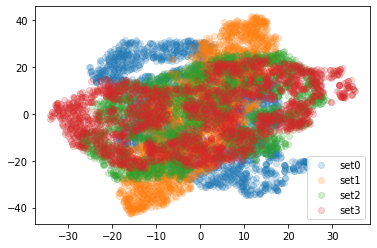

In [205]:
def TSNE_plots(dataset_list):
  random_state=42
  plt.figure(figsize=(12,12))
  fig, ax = plt.subplots()
  for k,entry in enumerate(dataset_list):
    print(f"running TSNE for entry {k}")
    result = TSNE(n_components=2, learning_rate='auto',init='random',random_state=random_state, perplexity=100).fit_transform(entry)
    df=pd.DataFrame(result,columns=[["x","y"]])
    ax.scatter(y=df["x"],x=df["y"],alpha=0.2,label=f"set{k}")
    ax.legend()
TSNE_plots(dataset_list)

In [139]:
pTOP_1_7_syn = api.artifact(f'ecg_simula/AE_pTOP_serverrun_synthetic_data/Model:v1', type='Model')
pTOP_1_7_syn.download(f"/content/artifacts/pTOP_1_7_version0")
#set up 1to7 models for prediction
syn1_7_path="/content/artifacts/pTOP_1_7_version0/model"
model_1to7_syn.load_state_dict(torch.load(syn1_7_path, map_location=device))
syn7_7_path="/content/artifacts/pTOP_7_7_syn/model"
model_7to7_syn.load_state_dict(torch.load(syn7_7_path, map_location=device))

wandb:   1 of 1 files downloaded.  


<All keys matched successfully>

In [140]:
model=model_1to7_syn
#model=pTOP_1to7()
FE=model_7to7_syn
dataloader=test_loader
Latent_spaces_real = torch.empty((1,100), dtype=torch.float32)
Latent_spaces_predicted = torch.empty((1,100), dtype=torch.float32)
for x,y in tqdm(dataloader):
    model.eval()
    FE.eval()
    with torch.inference_mode():
      #get latent space of real data
      #only do this the first time, when testing several model states its unnesesary to run this more then once
      output_real=FE(y,LS=True)
      Latent_spaces_real = torch.cat((Latent_spaces_real, output_real.detach().cpu()), 0)
      #get latent space of predicted data
      output_predicted=model(x)
      output_predicted=FE(output_predicted,LS=True)
      Latent_spaces_predicted = torch.cat((Latent_spaces_predicted, output_predicted.detach().cpu()), 0)


  0%|          | 0/78 [00:00<?, ?it/s]

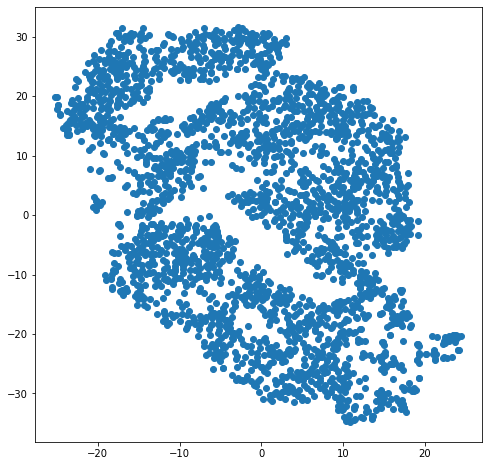

In [194]:
Result = TSNE(n_components=2, learning_rate='auto',init='random',random_state=42, perplexity=100).fit_transform(Latent_spaces_real_list[0])
df=pd.DataFrame(Result)
df.columns=["x","y"]
df.head()
plt.figure(figsize=(8,8))
# plt.scatter(x=df["x"],y=df["y"],z=df["z"])
plt.scatter(y=df["x"],x=df["y"])
plt.show()

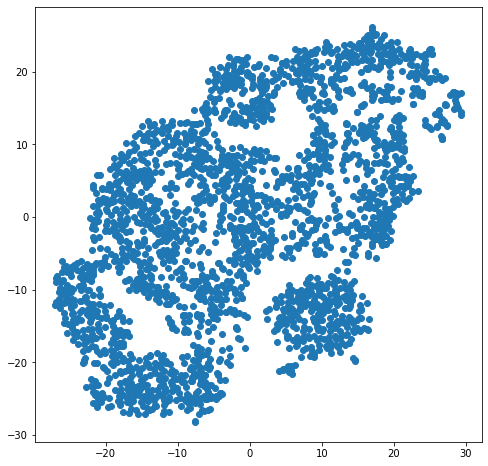

In [196]:
Result = TSNE(n_components=2, learning_rate='auto',init='random',random_state=42, perplexity=100).fit_transform(Latent_spaces_predicted_list[4])
df=pd.DataFrame(Result)
df.columns=["x","y"]
df.head()
plt.figure(figsize=(8,8))
# plt.scatter(x=df["x"],y=df["y"],z=df["z"])
plt.scatter(y=df["x"],x=df["y"])
plt.show()

In [207]:
!pip install umap-learn
!pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 29.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=b41a5dc5f33bf28cffea7325a3228997bfcf2257dad21204ed8413d4e207880f
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=2f0cdd345e2457f5e1c7b0bfad846807c952370e07948e17f61c2821295fd6c0
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 97 kB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
 

In [208]:
##use UMAP to compare latent spaces
## using UMAP
import umap.umap_ as umap
from sklearn.datasets import load_digits
embedding_real = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      n_components=2,
                      random_state=42,
                      metric='correlation').fit(Latent_spaces_real_list[0].data)

embedding_predicted = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      n_components=2,
                      random_state=42,
                      metric='correlation').fit(Latent_spaces_predicted_list[0].data)


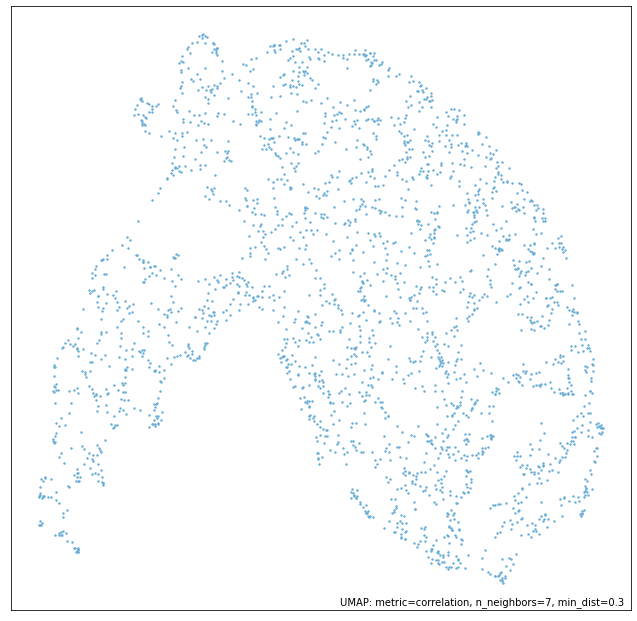

In [209]:
import umap.plot
umap.plot.points(embedding_real)

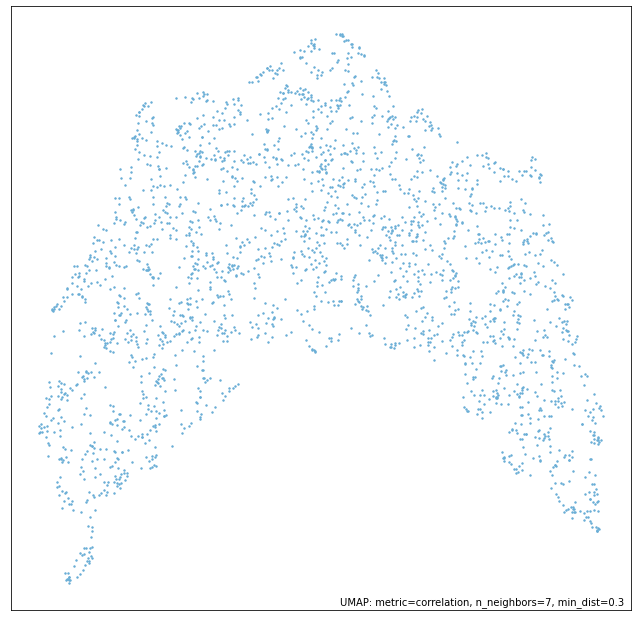

In [210]:
import umap.plot
umap.plot.points(embedding_predicted)